# Lab 3. Least squares analysis
#### Computational Methods for Geoscience - EPS 400/522
#### Instructor: Eric Lindsey

Due: Sept. 14, 2022

---------

In [1]:
# some useful imports and settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import datetime

# better looking figures on high-resolution screens
%config InlineBackend.figure_format = 'retina'

### Assignment 1. Fitting a line to the SST data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: COBE Sea Surface Temperature Analysis
    history: created June 2011 at ESRL/PSD using the grib data from JRA.
    platform: Analyses
    original_source: http://near-goos1.jodc.go.jp/cgi-bin/1997/near_goos_catalog?projectname=NEAR-GOOS
    Conventions: CF-1.2
    institution: NOAA ESRL/PSD
    comment: recent values (w/i last year) may change as dataset is updated. It is a monitoring dataset.
    dataset_title: COBE Sea Surface Temperature
    References: https://www.psl.noaa.gov/data/gridded/data.cobe.html
    dimensions(sizes): lon(360), lat(180), time(1590)
    variables(dimensions): float32 lat(lat), float32 lon(lon), float64 time(time), float32 sst(time, lat, lon)
    groups: 


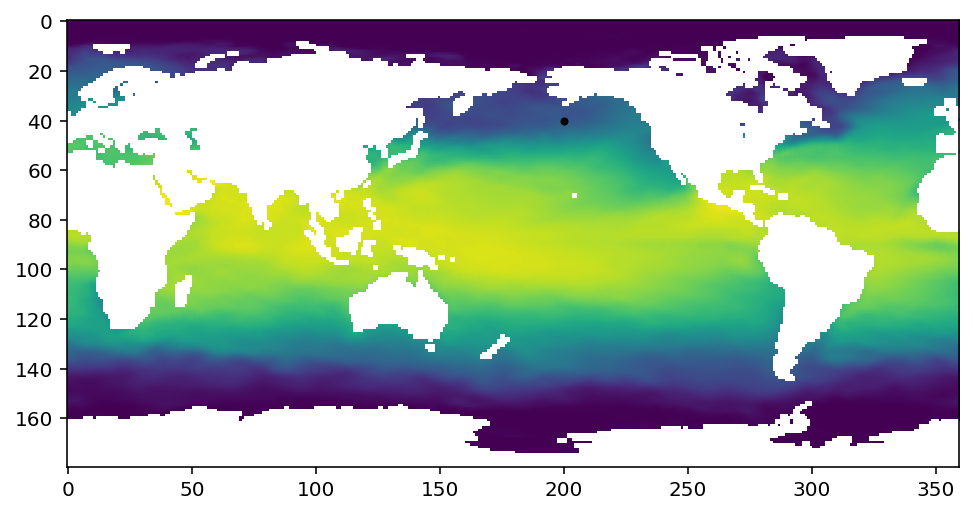

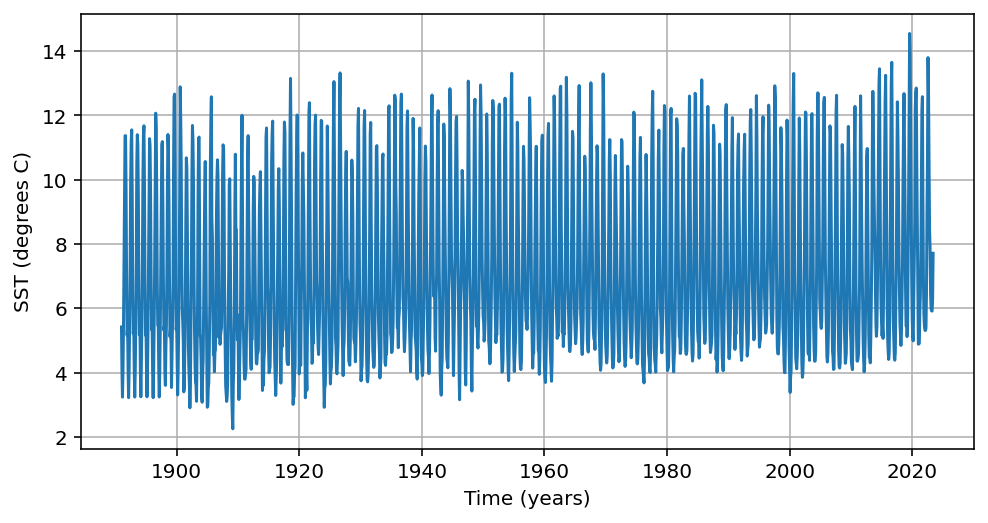

In [46]:
# Load in some of the data from the SST dataset last week
dataset = nc.Dataset('sst.mon.mean.nc')
print(dataset)
latest=dataset['sst'][-1,:,:]

# make a quick map:
plt.figure(figsize=(8,6))
plt.imshow(latest)

# choose the lat and lon location of our point and show it on the map:
ilon=200
ilat=40
plt.plot(ilon,ilat,'k.')

# finish the map
plt.show()

# extract one timeseries from the SST data, at this location.
# remember, this is stored as a 3D array, with the 3 indices meaning: (time,lat,lon) so that's how we slice the array.
timeseries=dataset['sst'][:,ilat,ilon]

dayslist=np.array(dataset['time'])
decyear = dayslist/365.25

start = datetime.datetime(1891,1,1)
dateslist=[]
for i in range(len(dataset['time'])):
    date = start + datetime.timedelta(int(dataset['time'][i]))
    dateslist.append(date)
    
plt.figure(figsize=(8,4))
plt.plot(dateslist,timeseries)
plt.ylabel('SST (degrees C)')
plt.xlabel('Time (years)')
plt.grid()

Do you see a trend in the data above? Use either the Linear Algebra approach or the Scipy approach to find out how fast the Pacific is warming off the coast of Baja California.

Your final result should include: 

- A plot of the SST values with the best-fitting line on top.
- The title of the plot should include the latitude and longitude, and the rate of ocean warming at this location - make sure to state the units, too. (Note: the variable I created above called "ilat" is not exactly the same as the true latitude of this point. You'll have to fix this!)
- Optional: do the calculation again for a new location. Include a map to show where you picked!

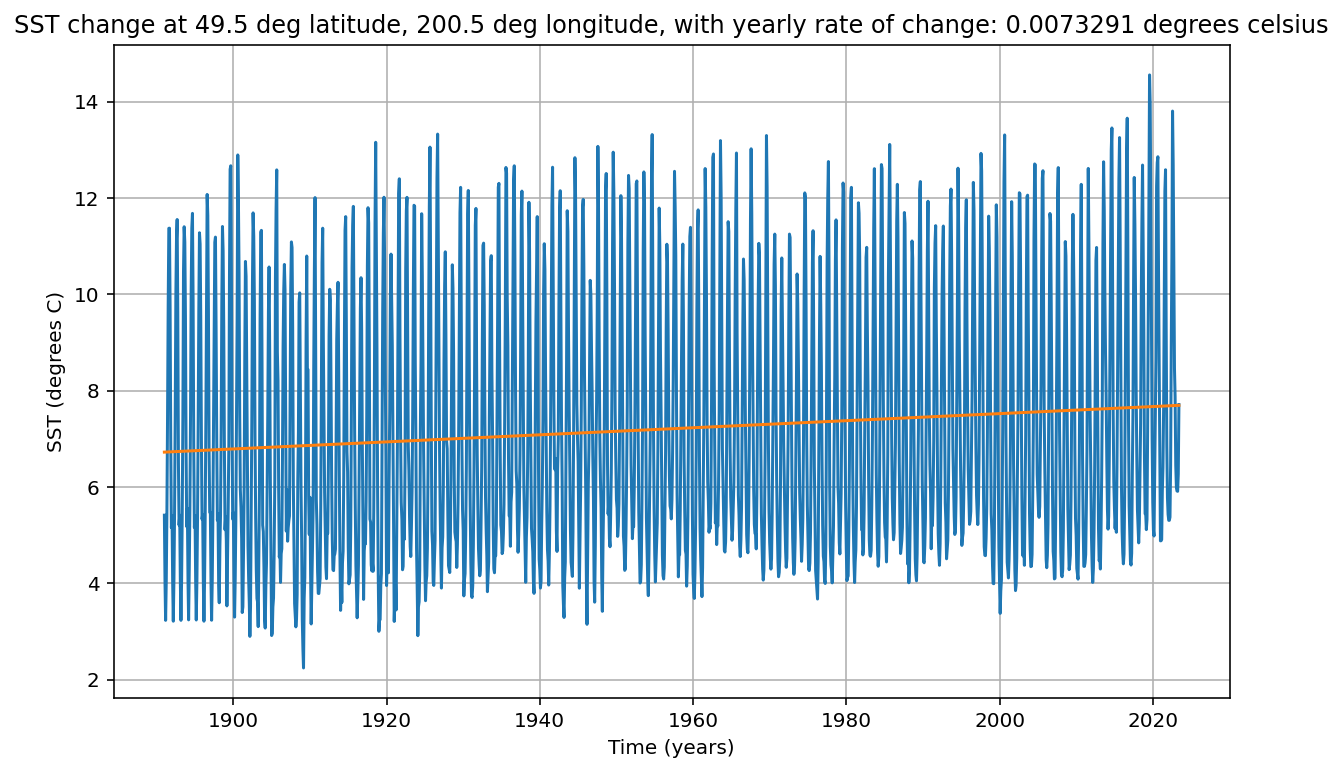

In [48]:
from scipy import stats

plt.figure(figsize=(10,6))
plt.plot(dateslist,timeseries)
plt.ylabel('SST (degrees C)')
plt.xlabel('Time (years)')
plt.grid()

slope, intercept, r_value, p_value, std_err = stats.linregress(decyear, timeseries)
plt.plot(dateslist, [intercept + slope * i for i in decyear])

yearly_rateofchange = round(slope,7)

lat = dataset['lat'][ilat]
lon = dataset['lon'][ilon]
title = (f'SST change at {lat} deg latitude, {lon} deg longitude, with yearly rate of change: {yearly_rateofchange} degrees celsius')
plt.title(title)
plt.show()


### Assignment 2. Fit lines to GPS data

1. Go to the following website: https://geodesy.unr.edu/NGLStationPages/gpsnetmap/GPSNetMap_MAG.html. This is a map showing the locations of several thousand GPS sites with processed data worldwide. Browse the global map of GPS data, and pick a site with some data that looks interesting - ideally with at least 5 years of data, a steady slope, and possibly an offset like in the example above. It may even have some nonlinear features, like a 'post-seismic' decay following a large earthquake. However, don't make your life too hard by picking a really complicated one, and also note that in the browse figures, the cyan lines represent equipment changes, and are not "real" geophysical signals, though we may need to account for them as unknown offsets in our fitting anyway. If you're worried about this being too complicated, I'd suggest looking for a site with a simple linear trend and no visible offsets.

2. Pick one site that you like, click on the plot to go to the site page, and download the 'tenv3' file (right click the link and choose save as...). You can choose whether to download the "IGS14" file, which uses a constant global 'average' reference frame for all the sites, so sites on different tectonic plates will have very different velocities, or you can download the plate-referenced file (for sites in North America these are labeled 'NA', for example). The second set will usually have much lower velocities since the reference frame is defined to move with that plate.

3. Read in these data using Pandas (note the tenv3 files are whitespace-delimited), and plot the 'yyyy.yyyy' (decimal year) column vs. the '__east(m)', '_north(m)' and '____up(m)' columns, optionally with 'sig_e(m)' 'sig_n(m)' 'sig_u(m)' for uncertainties (though it may make the plot too crowded). Use 3 subplots to make a nice plot of the data, similar to the figures on the MAGNET site.

4. Fit a line (or a curve) to each of the 3 components of the data, using any model parameters (linear or nonlinear) that you feel are appropriate for your data, and print out the E, N and U velocities of the site relative to whichever reference frame you chose. How close are you to the velocities reported on the MAGNET site (shown as inset text in the figures)?

Velocity east:  0.003254419047562493 meters per year
Velocity north:  0.003957543125459352 meters per year
Velocity upwards:  -0.001332454836061807 meters per year


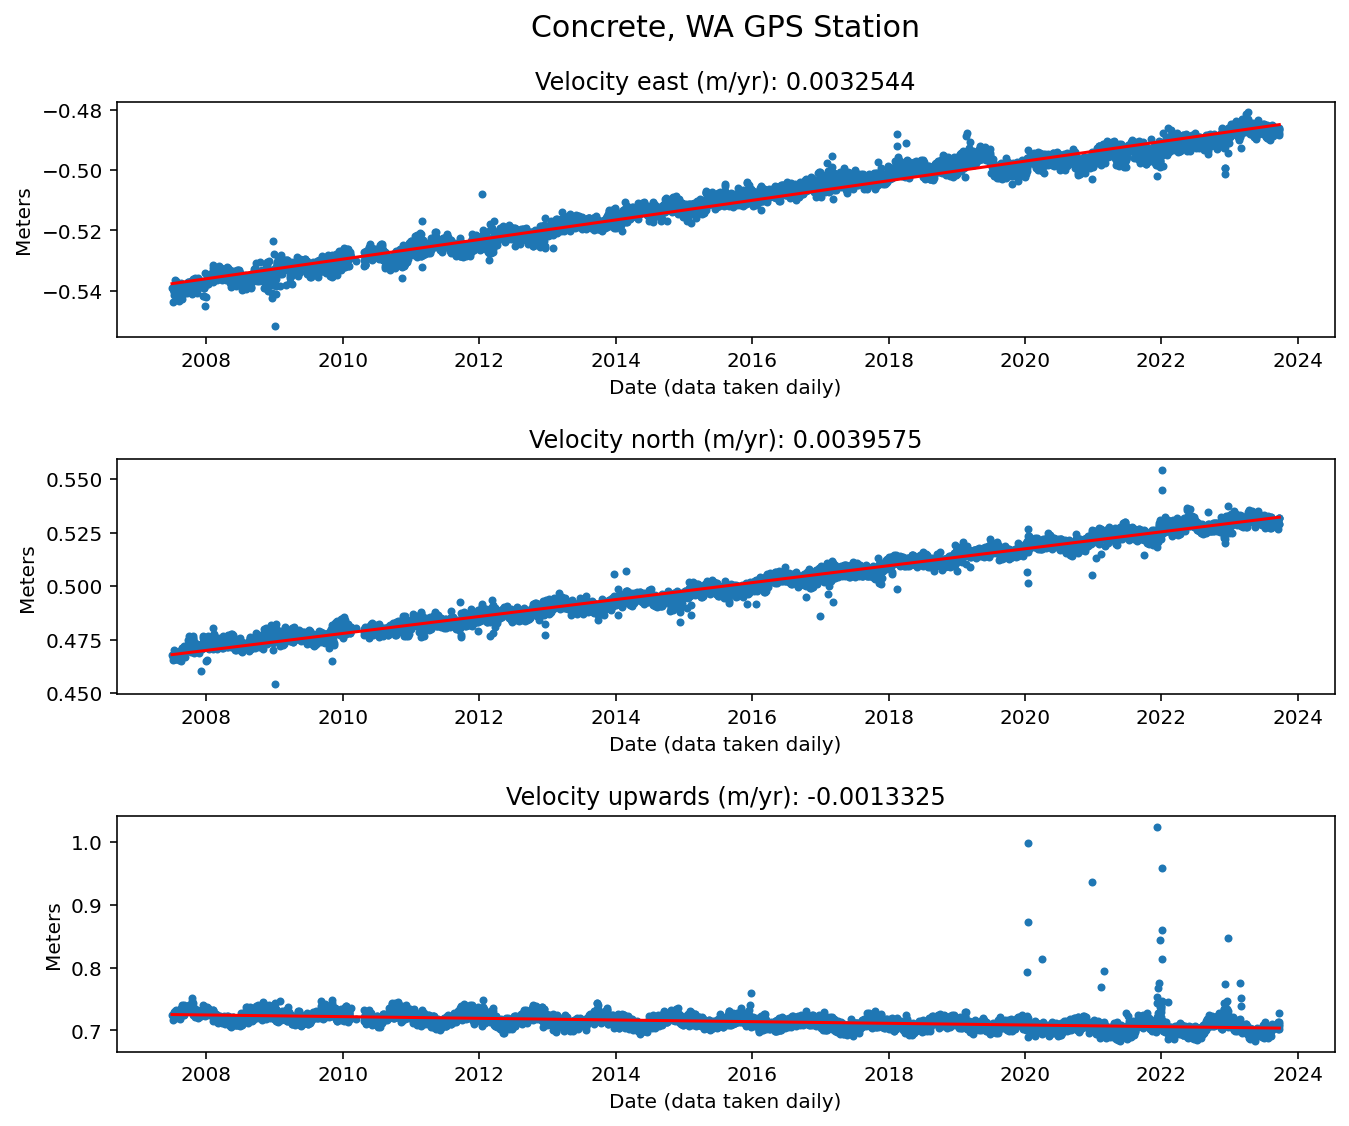

In [45]:
import scipy

dset = pd.read_csv('compmethods_concrete_GPS.tenv3',delim_whitespace=True)

change_east = dset['__east(m)']
change_north = dset['_north(m)']
change_up = dset['____up(m)']
time = dset['yyyy.yyyy']

def curve_func(x, a, b):
    return a + b*x

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10,8))
fig.tight_layout(pad=4)
plt.suptitle('Concrete, WA GPS Station', size=15, x=0.51, y=1)

m2,mcov = scipy.optimize.curve_fit(curve_func,time,change_east,p0=[0,0])
east_predicted = curve_func(time,*m2)
ax1.plot(time,change_east, '.')
ax1.plot(time,east_predicted,'-r')
slope, intercept, r_value, p_value, std_err = stats.linregress(time, east_predicted)
print('Velocity east: ', slope ,'meters per year')
ax1.set_title(f'Velocity east (m/yr): {round(slope,7)}')
ax1.set_xlabel('Date (data taken daily)')
ax1.set_ylabel('Meters')

m3, mcov = scipy.optimize.curve_fit(curve_func,time,change_north,p0=[0,0])
north_predicted = curve_func(time,*m3)
ax2.plot(time,change_north, '.')
ax2.plot(time,north_predicted, '-r')
slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(time, north_predicted)
print('Velocity north: ', slope2, 'meters per year')
ax2.set_title(f'Velocity north (m/yr): {round(slope2,7)}')
ax2.set_xlabel('Date (data taken daily)')
ax2.set_ylabel('Meters')

m4, mcov = scipy.optimize.curve_fit(curve_func,time,change_up,p0=[0,0])
up_predicted = curve_func(time,*m4)
ax3.plot(time,change_up, '.')
ax3.plot(time,up_predicted, '-r')
slope3, intercept3, r_value3, p_value3, std_err3 = stats.linregress(time, up_predicted)
print('Velocity upwards: ', slope3, 'meters per year')
ax3.set_title(f'Velocity upwards (m/yr): {round(slope3,7)}')
ax3.set_xlabel('Date (data taken daily)')
ax3.set_ylabel('Meters')

plt.show()